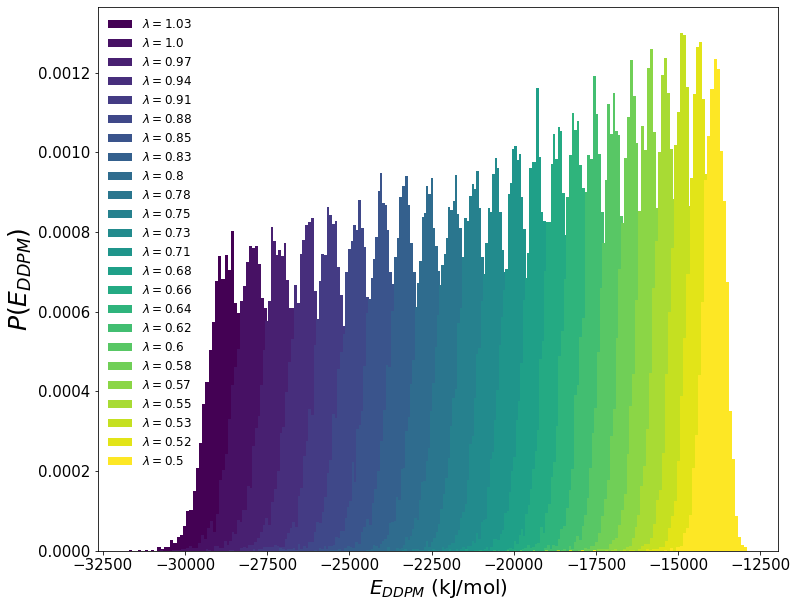

In [1]:
# Compute Eddpm



import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the energy function that models the relationship between the rescaling factor (l) and energy parameters.
def energy_function(l, epp1, epw, eww):
    # l: rescaling factor, epp1: protein-protein interaction, epw: protein-water interaction, eww: water-water interaction
    return l*epp1 + np.sqrt(l)*epw + eww

nrep = 24 # Number of replicas for REST2.
nframes = 6000 # Number of frames per replica.
nstruc = nrep*nframes #Total number of structures from REST2, obtained from the concatenated replicas.
lamb = np.array([1.03092784, 1.        , 0.96774194, 0.9375    , 0.90909091,
       0.8797654 , 0.85227273, 0.82644628, 0.8       , 0.7751938 ,
       0.7518797 , 0.72815534, 0.70588235, 0.6833713 , 0.66225166,
       0.64239829, 0.62240664, 0.60362173, 0.58479532, 0.56710775,
       0.54945055, 0.53285968, 0.51635112, 0.5       ]) # 1D Numpy array of shape (nrep) containing the values of the rescaling factor of each replica.

energy = np.load("potential_energy.npy")

# energy is a 2D Numpy-array of shape (nstruc,nrep) where energy[i][j] represents the potential energy of structure i,
# computed with the rescaled Hamiltonian of replica j.
# It must be defined or loaded before this point.


# Initialize lists to store the fitted parameters for each structure.
Epp = []  # Stores fitted protein-protein interaction for each structure
Epw = []  # Stores fitted protein-water interaction for each structure
Eww = []  # Stores fitted water-water interaction for each structure
pcovs = []  # Stores the covariance matrices of the fitted parameters for each structure

# Fit the energy function to each structure's data
for t in range(nstruc):
    # Curve fitting to find the parameters that best fit the energy function to the data
    popt, pcov = curve_fit(energy_function, lamb, energy[t])
    Epp.append(popt[0])  # Append the fitted parameter 1
    Epw.append(popt[1])  # Append the fitted parameter 2
    Eww.append(popt[2])  # Append the fitted parameter 3
    pcovs.append(pcov)  # Append the covariance matrix

# Convert lists of fitted parameters to numpy arrays for easier manipulation
Epp = np.array(Epp)
Epw = np.array(Epw)
Eww = np.array(Eww)

# Initialize variables for computing modified energies for DDPM learning
Eddpm = []  # Initialize list to store rescaled energy values for DDPM learning

# Compute the rescaled energies for each replica
for i in range(nrep):
    # Compute modified energy using fitted parameters and the rescaling factor for each replica
    e = lamb[i]*Epp[i*nframes:(i+1)*nframes] + np.sqrt(lamb[i])*Epw[i*nframes:(i+1)*nframes]
    Eddpm.append(e)

# Convert the list of modified energies to a numpy array
Eddpm = np.array(Eddpm)
f = np.save("Eddpm.npy",Eddpm)


#Plot the distribution of the Eddpm for the different replicas
cmap = plt.get_cmap('viridis')

colors = cmap(np.linspace(0,1,len(Eddpm)))

plot=plt.figure(figsize=(12.2, 10))
for i in range(nrep):
    plt.hist(Eddpm[i],bins = 50,label = r"$\lambda = $" + str(round(lamb[i],2)),color = colors[i],density= True)
plt.legend(fontsize = 12,frameon = False,loc = "upper left")
plt.xlabel(r"$E_{DDPM}$ (kJ/mol)",fontsize = 20)
plt.ylabel(r"$P(E_{DDPM})$",fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

In [2]:
# Make training set for DDPM


import numpy as np

nrep = 24  # Number of replicas for REST2.
nframes = 6000  # Number of frames per replica.

# Load the rescaled potential energies and collective variables arrays
Eddpm = np.load("Eddpm.npy")  # Rescaled potential energy array, shape (nrep, nframes)
d_181_112 = np.load("d_181_112.npy")  # Collective variable, shape (nrep, nframes)
d_181_221 = np.load("d_181_221.npy")  # Collective variable, shape (nrep, nframes)
psi_181 = np.load("psi_181.npy")  # Collective variable, shape (nrep, nframes)
phi_182 = np.load("phi_182.npy")  # Collective variable, shape (nrep, nframes)

# DDPM will learn P(d_181_112, d_181_221, psi_181, phi_182, Eddpm).

# Indices for discarding the initial equilibration part of the simulation
xmn = 1001  # Start index for usable data
xmx = len(Eddpm[0])  # End index, should be equal to nframes

# Calculate the number of structures per replica used in training, after discarding equilibration
nstruc_per_replica = len(Eddpm[0][xmn:xmx])

# Initialize an array for the training data with appropriate dimensions
training_data = np.zeros(((nstruc_per_replica) * nrep, 5))

count = 0  # Initialize counter for filling training_data
for i in range(nrep):
    for j in range(nstruc_per_replica):
        # Populate training_data with Eddpm and the collective variables for each structure
        training_data[count][0] = Eddpm[i][j + xmn]
        training_data[count][1] = d_181_112[i][j + xmn]
        training_data[count][2] = d_181_221[i][j + xmn]
        training_data[count][3] = psi_181[i][j + xmn]
        training_data[count][4] = phi_182[i][j + xmn]
        count += 1

# Save the prepared training_data array for future use
np.save("traj_REST2/training_data_traj.npy",training_data)

Sum of normalized probabilities: 1.0


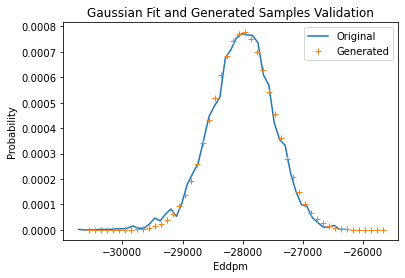

In [3]:
# Make Eddpm for generation


import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Load the training data previously prepared
training_data = np.load("traj_REST2/training_data_traj.npy")

nrep = 24  # Number of replicas for REST2.

def gaussian(x, mu, sigma):
    """Gaussian distribution function for curve fitting."""
    return (1 / (sigma * (2 * np.pi) ** 0.5)) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)


# Number of frames per replica used for the training set
n_sample_per_replica = int(len(training_data) / nrep)

# Index of the reference replica for generating new samples
idx_reference_replica = 1

# Extract the energy values for the specified replica
energy_lamb = training_data[idx_reference_replica * n_sample_per_replica: (idx_reference_replica + 1) * n_sample_per_replica, 0]

# Compute the histogram of the energy values
hist, bins_edge = np.histogram(energy_lamb, bins=50)
bins_plot = (bins_edge[1:] + bins_edge[:-1]) * 0.5
prob = hist / (np.sum(hist) * (bins_plot[1] - bins_plot[0]))

# Normalize the probability distribution and ensure it sums to 1
print(f"Sum of normalized probabilities: {np.sum(prob) * (bins_plot[1] - bins_plot[0])}")

# Fit the Gaussian model to the probability distribution
popt, pcov = curve_fit(gaussian, bins_plot, prob, bounds=([np.mean(energy_lamb) - 1000, 0.], [np.mean(energy_lamb) + 1000, 3 * np.std(energy_lamb)]))

# Generate new samples from the fitted Gaussian distribution
samples = np.random.normal(popt[0], popt[1], 1000000)

# Validate the generated samples by plotting histograms
hist_samples, bins_edge_samples = np.histogram(samples, bins=50)
bins_plot_samples = (bins_edge_samples[1:] + bins_edge_samples[:-1]) * 0.5
prob_samples = hist_samples / (np.sum(hist_samples) * (bins_plot_samples[1] - bins_plot_samples[0]))

# Plotting the comparison
plt.figure()
plt.plot(bins_plot, prob, ls="-", marker="None", label="Original")
plt.plot(bins_plot_samples, prob_samples, ls="None", marker="+", label="Generated")
plt.legend()
plt.xlabel("Eddpm")
plt.ylabel("Probability")
plt.title("Gaussian Fit and Generated Samples Validation")
plt.show()

# Prepare the energy samples for saving
nrj_sample = np.array(samples).reshape(-1, 1)

# Save the generated samples for the specified replica
np.save(f"traj_REST2/sample_energy_lambda_{idx_reference_replica}_traj.npy", nrj_sample)